# Hand Gesture Model Training
**Architecture:** MediaPipe Landmarks (63 features) → TensorFlow Dense Neural Network → 6 Gesture Classes

This is much better than a CNN on raw images because:
- 63 numbers vs 128×128×3 = 49,152 pixels — 780× smaller input
- Invariant to lighting, background, skin tone
- Trains in **under 1 minute** instead of 30 minutes
- Higher accuracy on limited data

## Pipeline
1. Load CSV of landmarks collected by `collect_data.py`
2. Normalize + split train/test
3. Build small Dense TF model
4. Train, evaluate, save


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

print(f'TensorFlow  : {tf.__version__}')
print(f'Keras       : {keras.__version__}')
print(f'GPU devices : {tf.config.list_physical_devices("GPU")}')

TensorFlow  : 2.20.0
Keras       : 3.13.2
GPU devices : []


## 1. Load & Inspect Data

In [2]:
CSV_PATH = '../data/landmarks.csv'

GESTURES = {
    0: 'palm',
    1: 'index',
    2: 'peace',
    3: 'fist',
    4: 'thumb_pinky',
    5: 'okay'
}
NUM_CLASSES    = len(GESTURES)
INPUT_FEATURES = 63   # 21 landmarks x 3 (x, y, z)

df = pd.read_csv(CSV_PATH)
print(f'Total samples : {len(df)}')
print(f'Columns       : {len(df.columns)}  (1 label + {len(df.columns)-1} features)')
print(f'\nSamples per gesture:')
for gid, gname in GESTURES.items():
    count = (df['label'] == gid).sum()
    bar   = '#' * (count // 5)
    print(f'  {gname:12s} (id={gid}) : {count:5d}  {bar}')

Total samples : 3000
Columns       : 64  (1 label + 63 features)

Samples per gesture:
  palm         (id=0) :   500  ####################################################################################################
  index        (id=1) :   500  ####################################################################################################
  peace        (id=2) :   500  ####################################################################################################
  fist         (id=3) :   500  ####################################################################################################
  thumb_pinky  (id=4) :   500  ####################################################################################################
  okay         (id=5) :   500  ####################################################################################################


## 2. Prepare Features & Labels

In [3]:
X = df.drop('label', axis=1).values.astype(np.float32)  # shape (N, 63)
y = df['label'].values

# One-hot encode labels
y_cat = tf.keras.utils.to_categorical(y, NUM_CLASSES)

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

print(f'Train samples : {len(X_train)}')
print(f'Test  samples : {len(X_test)}')
print(f'Feature shape : {X_train.shape}')

Train samples : 2400
Test  samples : 600
Feature shape : (2400, 63)


## 3. Build TensorFlow Model

In [4]:
def build_model(input_dim=63, num_classes=6):
    """
    Dense neural network for landmark classification.
    Input  : 63 normalized landmark coordinates
    Output : softmax over 6 gesture classes
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax'),
    ], name='gesture_landmark_model')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "gesture_landmark_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,718 (233.27 KB)

 Trainable params: 58,822 (229.77 KB)

 Non-trainable params: 896 (3.50 KB)

## 4. Train

In [5]:
os.makedirs('../models', exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        '../models/best_gesture_model.h5',
        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1
    ),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7968 - loss: 0.6771
Epoch 1: val_accuracy improved from None to 0.65500, saving model to ../models/best_gesture_model.h5



Epoch 1: finished saving model to ../models/best_gesture_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9337 - loss: 0.2481 - val_accuracy: 0.6550 - val_loss: 1.3521 - learning_rate: 0.0010
Epoch 2/100
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0286
Epoch 2: val_accuracy improved from 0.65500 to 0.73500, saving model to ../models/best_gesture_model.h5



Epoch 2: finished saving model to ../models/best_gesture_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0267 - val_accuracy: 0.7350 - val_loss: 1.0290 - learning_rate: 0.0010
Epoch 3/100
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0195
Epoch 3: val_accuracy improved from 0.73500 to 0.83333, saving model to ../models/best_gesture_model.h5



Epoch 3: finished saving model to ../models/best_gesture_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0193 - val_accuracy: 0.8333 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 4/100
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0177
Epoch 4: val_accuracy improved from 0.83333 to 1.00000, saving model to ../models/best_gesture_model.h5



Epoch 4: finished saving model to ../models/best_gesture_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 5/100
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0096
Epoch 5: val_accuracy did not improve from 1.00000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 6/100
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0061
Epoch 6: val_accuracy did not improve from 1.00000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 7/100
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0047
Epoch 7: val_accuracy did not improve from 1.00000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 

## 5. Evaluate

In [6]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss     : {loss:.4f}')
print(f'Test Accuracy : {acc*100:.2f}%')

y_pred        = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print('\nClassification Report:')
print(classification_report(y_true_labels, y_pred_labels, target_names=GESTURES.values()))

Test Loss     : 0.0000
Test Accuracy : 100.00%

Classification Report:
              precision    recall  f1-score   support

        palm       1.00      1.00      1.00       100
       index       1.00      1.00      1.00       100
       peace       1.00      1.00      1.00       100
        fist       1.00      1.00      1.00       100
 thumb_pinky       1.00      1.00      1.00       100
        okay       1.00      1.00      1.00       100

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



## 6. Visualise Results

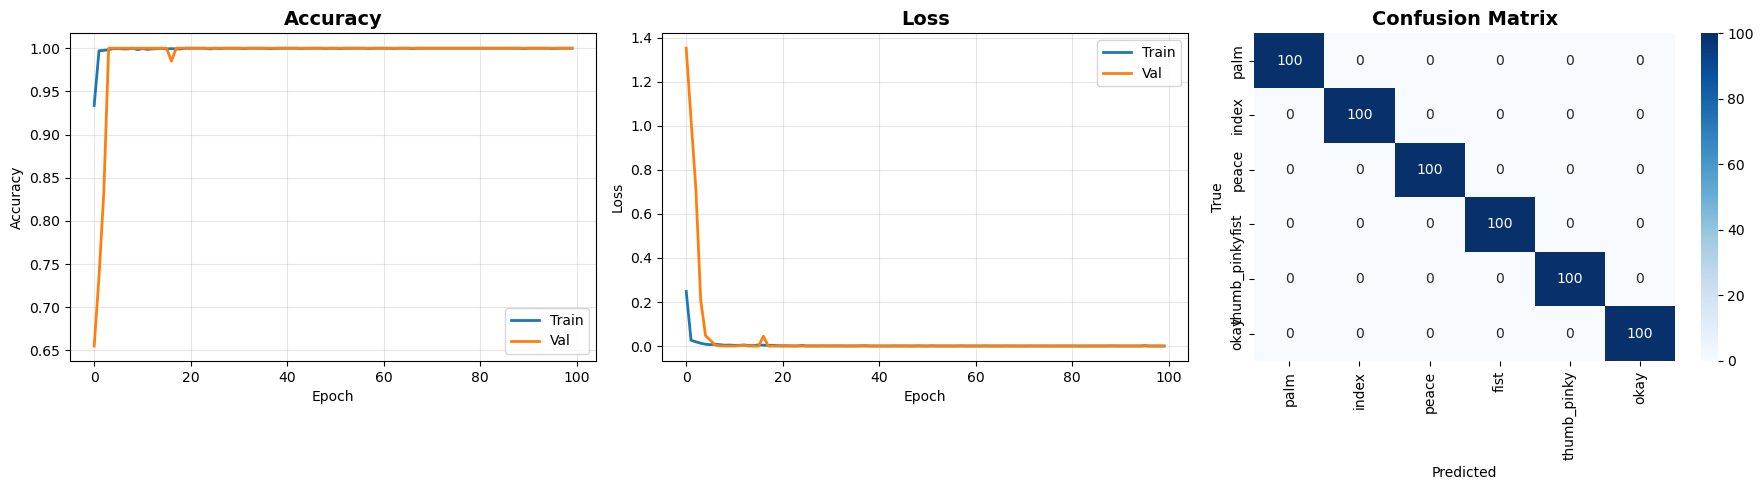

Plot saved to ../models/training_results.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy curve
axes[0].plot(history.history['accuracy'],     label='Train', lw=2)
axes[0].plot(history.history['val_accuracy'], label='Val',   lw=2)
axes[0].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(alpha=0.3)

# Loss curve
axes[1].plot(history.history['loss'],     label='Train', lw=2)
axes[1].plot(history.history['val_loss'], label='Val',   lw=2)
axes[1].set_title('Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(alpha=0.3)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=GESTURES.values(), yticklabels=GESTURES.values())
axes[2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[2].set_ylabel('True'); axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('../models/training_results.png', dpi=150)
plt.show()
print('Plot saved to ../models/training_results.png')

## 7. Save Model & Mapping

In [8]:
# Save final model
model.save('../models/gesture_model.h5')
print('Model saved : ../models/gesture_model.h5')

# Save gesture mapping (id -> name)
with open('../models/gesture_mapping.json', 'w') as f:
    json.dump({str(k): v for k, v in GESTURES.items()}, f, indent=4)
print('Mapping saved: ../models/gesture_mapping.json')

print('\n--- Training complete ---')
print(f'Final accuracy : {acc*100:.2f}%')
print('\nNext step: run gesture_controller.py')

Model saved : ../models/gesture_model.h5
Mapping saved: ../models/gesture_mapping.json

--- Training complete ---
Final accuracy : 100.00%

Next step: run gesture_controller.py


## 8. Quick Test (Optional)
Load the saved model and verify it predicts correctly on a few test samples.

In [9]:
loaded_model = tf.keras.models.load_model('../models/gesture_model.h5')

# Test on 5 random samples
indices = np.random.choice(len(X_test), 5, replace=False)
for idx in indices:
    sample    = X_test[idx:idx+1]
    pred      = loaded_model.predict(sample, verbose=0)[0]
    pred_id   = np.argmax(pred)
    true_id   = np.argmax(y_test[idx])
    confidence= pred[pred_id] * 100
    match     = 'CORRECT' if pred_id == true_id else 'WRONG'
    print(f'  True: {GESTURES[true_id]:12s}  '
          f'Pred: {GESTURES[pred_id]:12s}  '
          f'Conf: {confidence:5.1f}%  {match}')

  True: okay          Pred: okay          Conf: 100.0%  CORRECT
  True: okay          Pred: okay          Conf: 100.0%  CORRECT
  True: fist          Pred: fist          Conf: 100.0%  CORRECT
  True: fist          Pred: fist          Conf: 100.0%  CORRECT
  True: index         Pred: index         Conf: 100.0%  CORRECT
